### troubleshooting optimization performance in `wobble`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings  
with warnings.catch_warnings():  # suppress annoying TensorFlow FutureWarnings 
    warnings.filterwarnings("ignore",category=FutureWarning)
    import wobble

#### viewing more optimization info:

set up the basics (see demo notebook for more explanation):

In [2]:
data = wobble.Data('../data/51peg_e2ds.hdf5')
results = wobble.Results(data)

In [3]:
r = 67 # index into data.orders for the desired order
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')

toggle on the `save_history` keyword (which is `False` by default) to generate a wobble.History object when optimizing the order -- this object will keep track of the best-fit parameters and goodness-of-fit metric at each step of the optimization:

  0%|          | 0/40 [00:00<?, ?it/s]

optimize: iterating through 40 optimization steps...


100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


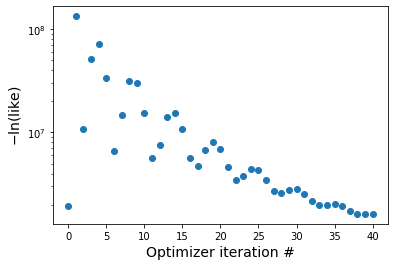

In [4]:
history = wobble.optimize_order(model, niter=40, save_history=True, rv_uncertainties=False)

The `wobble.History` class includes several convenience functions for plotting - here are a couple of examples:

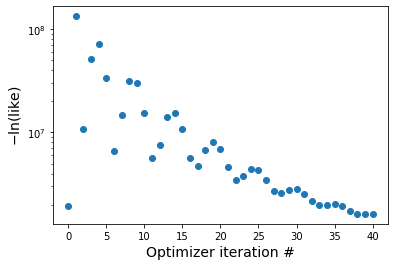

In [5]:
history.plot_nll();

In [6]:
template_ani_star = history.plot_template(0, nframes=50)

In [7]:
from IPython.display import HTML
HTML(template_ani_star.to_html5_video())

#### tuneable knobs in wobble:

What if the optimization doesn't appear to be performing well? A few things to check:
- Is the optimization being run long enough? 

*If the -log(likelihood) graph shows that the fit is still actively improving during the last optimizer iterations, it might need to be iterated further. This can be fixed by changing the `niter` keyword:*

  0%|          | 0/60 [00:00<?, ?it/s]

optimize: iterating through 60 optimization steps...


100%|██████████| 60/60 [00:26<00:00,  2.27it/s]


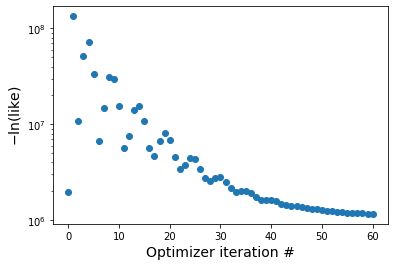

In [8]:
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')
history = wobble.optimize_order(model, niter=60, save_history=True, rv_uncertainties=False)

- Do the optimizer learning rates work well?

*`wobble` uses the [Tensorflow implementation of the Adam optimizer](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/optimizers/Adam), a gradient-based method. The performance of Adam can be sensitive to the learning rate used. Basically, a small learning rate means that the optimizer takes small steps along the gradient descent with each iteration, which can be inefficient and take a long time. On the other hand, a large learning rate leads to large steps which can overshoot, leading to the "ringing" effect seen in some of the previous plots.*

*The learning rates can be tuned with keyword arguments at the stage of adding the components. This is because each component - and within the component, each set of variables (spectral template, RVs, basis vectors, basis weights) - have independent optimizer instances with their own learning rate.*

In [9]:
# print the current (default) settings:
for c in model.components:
    if not c.template_fixed:
        print('template learning rate for {0}: {1:.0e}'.format(c.name, c.learning_rate_template))
    if not c.rvs_fixed:
        print('RVs learning rate for {0}: {1:.0e}'.format(c.name, c.learning_rate_template))

template learning rate for star: 1e-01
RVs learning rate for star: 1e-01
template learning rate for tellurics: 1e-02


  0%|          | 0/60 [00:00<?, ?it/s]

optimize: iterating through 60 optimization steps...


100%|██████████| 60/60 [00:30<00:00,  1.96it/s]


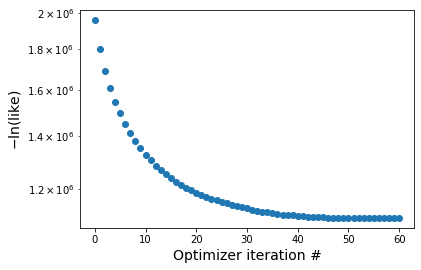

In [10]:
model = wobble.Model(data, results, r)
model.add_star('star', learning_rate_template=0.001)
model.add_telluric('tellurics', learning_rate_template=0.001)
history = wobble.optimize_order(model, niter=60, save_history=True, rv_uncertainties=False)

That was probably a better choice of learning rates, since the wiggles went away! Note that there can be a tradeoff between learning rates and number of iterations, since a lower learning rate might require more iterations to reach a steady state. It's worth checking to verify that your "improved" chocie of learning rates still reaches a -ln(like) value that is the same as or smaller than previous optimization attempts.